# ECE763 Project 03 (Final Course Project): Self-Supervised Learning

### Objectives

* Implemenet two self-supervised contrastive learning methods
* Compare the representaitons via SSL with supervised baseline

### How to submit your solutions

* Add your NCSU IDs (all team members if had) as the postfix of the notebook filename.
* `If you have a team, please clearly state who contribute to which part(s) of the project.`
* Submit two versions of your notebook, one is fully executed with all outputs (`Project_03_ViT_twu19_results.ipynb`), and the other with all outputs cleared (`Project_03_ViT_twu19_empty.ipynb`). We will re-run the latter and expect the results will be exactly the same as those in the former. 
* No late days

### Team Contributions (if applicable)

* 
*
*

### Overview

How to learn good representations from unlabeled data (e.g., imagery data)? First of all, this data still contains a lot of information from which we can learn: how are the images different from each other? What patterns are descriptive for certain images? Can we cluster the images? And so on. Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task. 

The benefit of self-supervised learning is that a large dataset can often easily be obtained. For instance, if we want to train a vision model on semantic segmentation for autonomous driving, we can collect large amounts of data by simply installing a camera in a car, and driving through a city for an hour. In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model. This is extremely expensive, and would likely take a couple of months to manually label the same amount of data. Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last several years, a lot of new approaches have been proposed for self-supervised learning using images, that have resulted in great improvements over supervised models when few labels are available.

Check our lecture notes 18-19 and references therein.




## Let's first start with importing our standard libraries below

In [1]:


## Standard libraries
import os
from copy import deepcopy
import json
import math
import random
import numpy as np 
import copy
import time

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme()

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10,STL10
from torchvision import transforms


# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard


## Identify the system

In [2]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

======================================== System Information ========================================
System: Linux
Node Name: jupyter-yazhuog
Release: 5.15.0-119-generic
Version: #129-Ubuntu SMP Fri Aug 2 19:25:20 UTC 2024
Machine: x86_64
Processor: x86_64
======================================== Environment Information ========================================
OrderedDict([('sys.platform', 'linux'),
             ('Python',
              '3.11.8 | packaged by conda-forge | (main, Feb 16 2024, '
              '20:53:32) [GCC 12.3.0]'),
             ('CUDA available', True),
             ('MUSA available', False),
             ('numpy_random_seed', 2147483648),
             ('GPU 0,1', 'NVIDIA A100-SXM4-40GB'),
             ('CUDA_HOME', None),
             ('GCC', 'gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0'),
             ('PyTorch', '2.2.0+cu121'),
             ('PyTorch compiling details',
              'PyTorch built with:\n'
              '  - GCC 9.3\n'
              '  - C++ Versio

## General settings

In [3]:


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../checkpoint/ece763-proj_03"

# Setting the seed
pl.seed_everything(42)
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
# NUM_WORKERS = 0

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cuda:0
Number of workers: 64


# Get started with implementing SimCLR

It is a method of self-supervised `contrastive` learning. Contrastive learning is motivated by the question mentioned above: how are images different from each other? Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized. A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al.](https://simclr.github.io/)).

<center width="100%"><img src="figures/simclr_contrastive_learning.png" width="500px"></center>

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward. During each training iteration, we sample a batch of images as usual. For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc. An example of such is shown on the left with the image of the dog. We will go into the details and effects of the chosen augmentation techniques later. On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP. The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible. This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

We will now implement this framework ourselves and discuss further details along the way. 

## Dataset

 We will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which, similarly to CIFAR10, contains images of 10 classes: `airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck`. However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class. Additionally, we have a much larger set of $100,000$ unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles. This makes the dataset ideal to showcase the benefits that self-supervised learning offers. 
 
 However, to reduce the computationally complexity, we will downscale the images back to $32\times 32$ pixels.  `Note: If you have sufficient GPU resources, you may try your implementation using` $96\times 96$.

Luckily, the STL10 dataset is provided through torchvision. Keep in mind, however, that since this dataset is relatively large and has a considerably higher resolution than CIFAR10, it requires more disk space (~3GB) and takes a bit of time to download. For our initial discussion of self-supervised learning and SimCLR, we will create two data loaders with our contrastive transformations above: the `unlabeled_data` will be used to train our model via contrastive learning, and `train_data_contrast` will be used as a validation set in contrastive learning.

### Data Augmentation for Contrastive Learning

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such. To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class `ContrastiveTransformations` below:

In [4]:
class ContrastiveTransformations(object):
    
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image. However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply. The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data. Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="figures/simclr_data_augmentations.png" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

All of them can be used, but it turns out that two augmentations stand out in their importance: crop-and-resize, and color distortion. Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al.](https://arxiv.org/abs/2006.10029) in their SimCLR paper. When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="figures/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view. However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space. Consider the picture of the dog above. Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture. In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features. If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore. Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.



In [5]:
# TODO data augmentaiton - [5 POINTS]
# Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup: 
# random horizontal flip, 
# crop-and-resize, 
# color distortion, 
# random grayscale, 
# and gaussian blur. 
# In comparison to the [original implementation](https://github.com/google-research/simclr), 
# we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue). 
# In our experiments, this setting obtained better performance and was faster and more stable to train. 
# If, for instance, the brightness scale highly varies in a dataset, the original settings can be more beneficial 
# since the model can't rely on this information anymore to distinguish between images.
# raise NotImplementedError
contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),  # crop-and-resize
    transforms.RandomHorizontalFlip(),       # random horizontal flip
    transforms.ColorJitter(                  # color distortion
        brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1
    ),
    transforms.RandomGrayscale(p=0.2),       # random grayscale
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),  # gaussian blur
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True, 
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Downscale images to 32x32 directly in arrays to save RAM and data loading computation
def downscale_dataset(dataset):
    data = dataset.data
    num_imgs = data.shape[0]
    new_data = np.zeros((num_imgs, data.shape[1], 32, 32), dtype=data.dtype)
    for i in tqdm(range(0, num_imgs, 100)):
        new_data[i:i+100] = transforms.functional.resize(torch.from_numpy(data[i:i+100]).float(), size=[32, 32]).to(torch.uint8).numpy()
    dataset.data = new_data
    
downscale_dataset(unlabeled_data)
downscale_dataset(train_data_contrast)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Finally, before starting with our implementation of SimCLR, let's look at some example image pairs sampled with our augmentations:

Seed set to 42


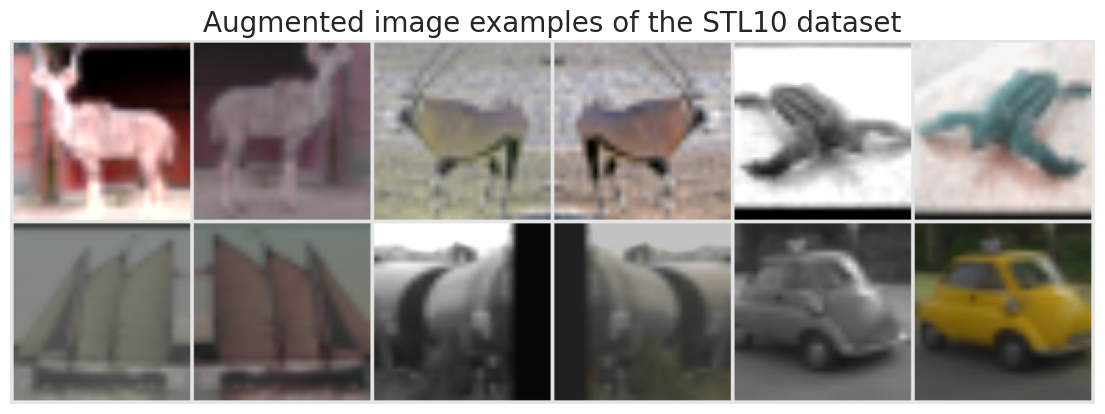

In [8]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(14,7))
plt.title('Augmented image examples of the STL10 dataset', fontsize=20)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion. Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

## Part 1: SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR. At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$. The base network is usually a deep CNN as we have seen before, and is responsible for extracting a representation vector from the augmented data examples. In our experiments, we will use a very simple `BaseNetwork` architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$. The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset. The general setup is visualized below (figure credit - [Ting Chen et al.](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="figures/simclr_network_setup.svg" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor. The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task. This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks. Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Let's first start by implementing a Base Network which will represent function $f(\cdot)$. Usually, you would use very large, powerful networks like a deep ResNet, but these are very expensive to train. To reduce the computational cost and make it possible to train the models with limited computong resources, we provide a very simple CNN here:

In [9]:
class BaseNetwork(nn.Module):

    def __init__(self, num_input_channels, c_hid, output_dim):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - c_hid : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - output_dim : Dimensionality of the final latent representation
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.BatchNorm2d(c_hid),
            nn.SiLU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_hid),
            nn.SiLU(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*c_hid, output_dim)
        )

    def forward(self, x):
        return self.net(x)

Now that the architecture is described, let's take a closer look at how we train the model. As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch. SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al.](https://arxiv.org/abs/1807.03748) for contrastive learning. In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values. The loss can be formally written as:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is. Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch. The similarity metric that is used in SimCLR is cosine similarity, as defined below:

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

The maximum cosine similarity possible is $1$, while the minimum is $-1$. In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [38]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # TODO: Setup the Base Network [5 POINTS]
        # raise NotImplementedError

        # Base model f(.)
        
        self.encoder = BaseNetwork(3, hidden_dim, hidden_dim)
        
        # The MLP for g(.) consists of Linear->ReLU->Linear
        
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch  # we do not need the labels here
        # imgs is a list of length 2, where imgs[0][i] and imgs[1][i] are the positive pairs

        # TODO: Calculate the contrastive loss of SimCLR. Try to be as efficient as possible [20 POINTS]
        # Hint: if you add imgs into a batch where over dimension 0, you have [imgs[0],imgs[1]],
        # the positive pair for an image at position i is always at (i + batch_size) % (2 * batch_size)
        # Can you create a mask to find the positive element for each batch element?
        
        x1, x2 = imgs
        batch_size = x1.size(0)

        # === Forward pass through f(.) and g(.) ===
        h1 = self.encoder(x1)  # [B, hidden_dim]
        h2 = self.encoder(x2)
        z1 = self.projection_head(h1)  # [B, hidden_dim]
        z2 = self.projection_head(h2)

        # Normalize the projections
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        # === Compute similarity matrix ===
        z = torch.cat([z1, z2], dim=0)  # [2B, D]
        sim = torch.matmul(z, z.T) / self.hparams.temperature  # [2B, 2B]

        # Mask out self-similarity
        self_mask = torch.eye(2 * batch_size, dtype=torch.bool, device=self.device)
        sim.masked_fill_(self_mask, float('-inf'))

        # Positive pair indices
        pos_indices = (torch.arange(2 * batch_size, device=self.device) + batch_size) % (2 * batch_size)
        pos_sim = sim[torch.arange(2 * batch_size), pos_indices]

        # Compute loss
        # loss = -pos_sim + torch.logsumexp(sim, dim=1).mean()
        loss = -torch.log_softmax(sim, dim=1)[torch.arange(2 * batch_size), pos_indices].mean()

        # === Metrics ===
        sim_argsort = sim.argsort(dim=1, descending=True)
        pos_rank = (sim_argsort == pos_indices.unsqueeze(1)).nonzero(as_tuple=True)[1]
        # raise NotImplementedError
        

        # Log the loss and the top-1 and top-5 accuracy as how often the most similar image was the positive
        self.log(mode + "_acc_top1", (pos_rank == 0).float().mean())
        self.log(mode + "_acc_top5", (pos_rank < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + pos_rank.float().mean())

        return loss

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model. We will use the same training function setup as usual. For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch. This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [11]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')],
                         check_val_every_n_epoch=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, 
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False, 
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS,persistent_workers=True)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients, but a batch size of 256 is sufficient here. Again, for a first run, you can use 10 epochs, but try to increase the number of epochs for a final run.

In [39]:
simclr_model = train_simclr(batch_size=256, 
                            hidden_dim=128, 
                            lr=5e-4, 
                            temperature=0.07, 
                            weight_decay=1e-4, 
                            max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name            | Type        | Params | Mode 
--------------------------------------------------------
0 | encoder         | BaseNetwork | 1.7 M  | train
1 | projection_head | Sequential  | 33.0 K | train
--------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.778     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [40]:
%tensorboard --logdir ../checkpoint/ece763-proj_03/SimCLR/

Reusing TensorBoard on port 6006 (pid 224638), started 2:59:42 ago. (Use '!kill 224638' to kill it.)

In your report, show the top-1 and top-5 accuracy validation curves. Discuss the overall performance and the training speed. Is the model already converged? What does the final performance of the model imply about the learned feature space?

<center width="100%"><img src="figures/train_acc_top1.png" width="1000px"></center>
<center width="100%"><img src="figures/train_acc_top5.png" width="1000px"></center>
<center width="100%"><img src="figures/val_acc_top1.png" width="1000px"></center>
<center width="100%"><img src="figures/val_acc_top5.png" width="1000px"></center>

**Discussion On Results**

The SimCLR model achieved near-perfect top-1 and top-5 accuracy on both training and validation sets, indicating excellent overall performance. Training converged efficiently, with all accuracy metrics stabilizing well before the final epoch. This rapid convergence suggests that the model quickly learned invariant features from augmented views. The final performance implies that the learned feature space is highly structured, with positive pairs tightly clustered and negatives well separated — enabling effective downstream classification even with limited labeled data.

## Part 2: Logistic Regression

After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data. A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features. In other words, we learn a single, linear layer that maps the representations to a class prediction. Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task. Further, we do not have to worry too much about overfitting since we have very few parameters that are trained. Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors. If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations. However, the way we implement it here is much more efficient and can be trained within a few seconds. Further, using data augmentations did not show any significant gain in this simple setup.

In [14]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        # Initialize logistic regression model        
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[int(self.hparams.max_epochs*0.6), 
                                                                  int(self.hparams.max_epochs*0.8)], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        # TODO: Calculate classification loss for logistic regression model [5 POINTS]
        # raise NotImplementedError
        x, y = batch  # x: features, y: ground-truth labels
        logits = self.model(x)  # shape: [batch_size, num_classes]
        loss = F.cross_entropy(logits, y)

        # Compute accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [41]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)
# downscale_dataset(train_img_data)
# downscale_dataset(test_img_data)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the Logistic Regression model.

In [16]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # TODO: Obtain the feature representation for all images in the dataset [5 POINTS]
    # raise NotImplementedError
    network = deepcopy(model.encoder)
    network.eval()
    network.to(device)

    # Encode all images
    dataloader = data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

    feats_list = []
    labels_list = []

    for imgs, labels in tqdm(dataloader, desc="Extracting features"):
        imgs = imgs.to(device)
        feats = network(imgs)  # [B, feature_dim]
        feats_list.append(feats.cpu())
        labels_list.append(labels.cpu())

    # Concatenate all features and labels
    feats = torch.cat(feats_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    # Return a new dataset with the image features and labels
    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [42]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

Extracting features:   0%|          | 0/40 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/63 [00:00<?, ?it/s]

Finally, we can write a training function as usual. We evaluate the model on the test set every 10 epochs to allow early stopping, but the low frequency of the validation ensures that we do not overfit too much on the test set.

In [18]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False, 
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets. Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification. First, let's define a function to create the intended sub-datasets from the full training set:

In [19]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    # TODO: Return dataset with the first N images per label [5 POINTS]
    # raise NotImplementedError
    label_to_indices = {}

    selected_indices = []

    for idx, (_, label) in enumerate(original_dataset):
        label = int(label)
        if label not in label_to_indices:
            label_to_indices[label] = []

        if len(label_to_indices[label]) < num_imgs_per_label:
            label_to_indices[label].append(idx)
            selected_indices.append(idx)

    new_dataset = data.Subset(original_dataset, selected_indices)
    
    return new_dataset

Next, let's run all models. Despite us training 6 models, this cell could be run within a minute or two without the pretrained models. 

In [43]:
# TODO: Run the logistic regression on datasets of 10, 20, 50, 100, 200, and 500 labeled examples [5 POINTS]
# raise NotImplementedError
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    print(f"\nTraining logistic regression with {num_imgs_per_label} images per class...")
    
    # Create smaller dataset
    small_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)

    # Train logistic regression
    model_suffix = f"simclr_{num_imgs_per_label}perclass"
    model, small_set_results = train_logreg(
        batch_size=256,
        train_feats_data=small_train_set,
        test_feats_data=test_feats_simclr,
        model_suffix=model_suffix,
        max_epochs=100,
        feature_dim=128,
        num_classes=10,  # STL10 has 10 classes
        lr=5e-1,
        weight_decay=1e-3
    )
    
    results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Training logistic regression with 10 images per class...


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.11/site-pa


Training logistic regression with 20 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training logistic regression with 50 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training logistic regression with 100 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training logistic regression with 200 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training logistic regression with 500 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finally, let's plot the results.

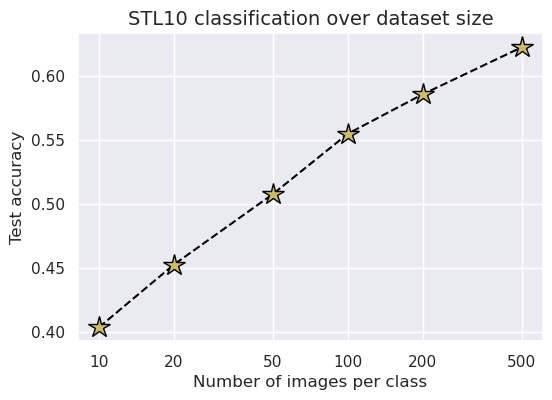

Test accuracy for  10 images per label: 40.36%
Test accuracy for  20 images per label: 45.26%
Test accuracy for  50 images per label: 50.77%
Test accuracy for 100 images per label: 55.49%
Test accuracy for 200 images per label: 58.57%
Test accuracy for 500 images per label: 62.25%


In [44]:
# Plot the results

dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")
    
    
# We should observe performance similar 
# Test accuracy for  10 images per label: 40.09%
# Test accuracy for  20 images per label: 43.75%
# Test accuracy for  50 images per label: 48.66%
# Test accuracy for 100 images per label: 52.79%
# Test accuracy for 200 images per label: 55.26%
# Test accuracy for 500 images per label: 58.28%

TODO: [5 POINTS] Discuss the overall performance as well as the trend you see in the plot. Where do you see the biggest jump in performance? Is the performance already saturating?

**Discussion On Results**

The logistic regression classifier trained on SimCLR features shows a clear upward trend in test accuracy as the number of labeled images per class increases. The most significant performance jump occurs between 50 and 100 images per class, where test accuracy improves from 50.77% to 55.49% — suggesting that this range provides enough labeled data to better define class boundaries in the feature space.

While accuracy continues to improve beyond this point, the rate of improvement slows, indicating that the performance is beginning to saturate. At 500 images per class, test accuracy reaches 62.25%, reflecting strong but not yet fully optimal separability. This plateau suggests that additional performance gains may require either more complex classifiers or enhancements to the representation space itself.

## Part 3: Baseline

As a baseline to our results above, we will train the BaseNetwork with random initialization on the labeled training set of STL10. The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training. First, let's implement it below.

In [22]:
class Baseline(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Initialize a base network
        self.model = BaseNetwork(num_input_channels=3, c_hid=48, output_dim=num_classes) 

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[int(self.hparams.max_epochs*0.7), 
                                                                  int(self.hparams.max_epochs*0.9)], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        # TODO: Calculate classification loss and accuracy [5 points]
        # raise NotImplementedError
        images, labels = batch
        logits = self.model(images)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        loss = self.loss_fn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size. To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur. Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification. Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations. Similarly, we restrict the resizing operation before cropping to the max. 125% of its original resolution, instead of 1250% as done in SimCLR. This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object. Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [23]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)
# downscale_dataset(train_img_aug_data)

Files already downloaded and verified


The training function for the BaseNetwork is almost identical to the Logistic Regression setup. Note that we allow the BaseNetwork to perform validation every 2 epochs to also check whether the model overfits strongly in the first iterations or not.

In [24]:
def train_baseline(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=2,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False, 
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = Baseline.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducable
        model = Baseline(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = Baseline.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

Finally, let's train the model and check its results. For a first run, use 10 epochs, but to obtain final results, try to train the model on more epochs.

In [25]:
baseline_model, baseline_result = train_baseline(batch_size=64,
                                               num_classes=10,
                                               lr=1e-3,
                                               weight_decay=2e-4,
                                               max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | BaseNetwork | 231 K  | train
----------------------------------------------
231 K     Trainable params
0         Non-trainable params
231 K     Total params
0.926     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [26]:
print(f"Accuracy on training set: {baseline_result['train']:.2%}")
print(f"Accuracy on test set: {baseline_result['test']:.2%}")

# We should observe performance similar to 
# Accuracy on training set: 67.03%
# Accuracy on test set: 60.29%

Accuracy on training set: 89.08%
Accuracy on test set: 73.68%


TODO: [5 POINTS] Discuss the results you have obtained from this baseline and compare it to the logistic regression model in Part 2. What do you see? What do the results imply?

**Discussion On Results**

The supervised baseline model achieves a training accuracy of 89.08% and a test accuracy of 73.68%, demonstrating strong generalization. Compared to the logistic regression model trained on SimCLR features (which reached 62.25% with 500 labeled samples per class), the baseline outperforms it by a margin of over 11 percentage points on the test set.

This performance gap suggests that while SimCLR provides meaningful representations, the end-to-end supervised training pipeline benefits from having access to full label supervision throughout the network, allowing it to fine-tune low-level features more effectively for the classification task. However, it also highlights SimCLR’s strength: achieving competitive performance without any label information during feature learning.

These results imply that self-supervised features are valuable, especially in low-label regimes, but may still fall short of fully supervised models when ample labeled data and training capacity are available.

## Summary of SimCLR

We have discussed self-supervised contrastive learning and implemented SimCLR as an example method. We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models. Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well. If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines. Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)). 


# Explore Another SSL Method

Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results. Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733), [SimSiam](https://arxiv.org/abs/2011.10566) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230). There is a lot more to explore in the self-supervised domain as briefly discssed in our lecture.


Implement `BYOL` or `SimSiam` or `BarlowTwins` to replace the SimCLR in Part 1 above, and re-do the experiments in Part 1 and Part 2.  With your new SSL method, compare with SimCLR and the baseline in Part 3. 

In [27]:
# Modify the interface as you see fit 

class AnotherSSL(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500, ema_decay=0.99):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"

        # Online encoder, projector, predictor
        self.encoder = BaseNetwork(3, c_hid=hidden_dim, output_dim=hidden_dim)
        self.projector = self._mlp(hidden_dim, hidden_dim)
        self.predictor = self._mlp(hidden_dim, hidden_dim)

        # Target encoder and projector (no predictor)
        self.target_encoder = copy.deepcopy(self.encoder)
        self.target_projector = copy.deepcopy(self.projector)

        # Freeze target params initially
        for param in self.target_encoder.parameters():
            param.requires_grad = False
        for param in self.target_projector.parameters():
            param.requires_grad = False

    def _mlp(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        p = self.predictor(z)
        return F.normalize(p, dim=1)

    @torch.no_grad()
    def _update_target_network(self):
        for online, target in zip(self.encoder.parameters(), self.target_encoder.parameters()):
            target.data = self.hparams.ema_decay * target.data + (1 - self.hparams.ema_decay) * online.data
        for online, target in zip(self.projector.parameters(), self.target_projector.parameters()):
            target.data = self.hparams.ema_decay * target.data + (1 - self.hparams.ema_decay) * online.data

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [scheduler]

    def compute_the_loss(self, batch, mode="train"):
        (x1, x2), _ = batch
        batch_size = x1.size(0)

        # === Online network ===
        h1 = self.encoder(x1)
        h2 = self.encoder(x2)
        z1 = self.projector(h1)
        z2 = self.projector(h2)
        p1 = self.predictor(z1)
        p2 = self.predictor(z2)

        # === Target network (no grad) ===
        with torch.no_grad():
            h1_target = self.target_encoder(x1)
            h2_target = self.target_encoder(x2)
            z1_target = self.target_projector(h1_target).detach()
            z2_target = self.target_projector(h2_target).detach()

        # === Loss: Negative Cosine Similarity ===
        loss_1 = 2 - 2 * F.cosine_similarity(p1, z2_target.detach(), dim=-1)
        loss_2 = 2 - 2 * F.cosine_similarity(p2, z1_target.detach(), dim=-1)
        loss = (loss_1 + loss_2).mean()

        self.log(f"{mode}_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.compute_the_loss(batch, mode="train")
        self._update_target_network()
        return loss

    def validation_step(self, batch, batch_idx):
        self.compute_the_loss(batch, mode="val")


In [28]:
# TODO: re-do experiments in Part 2 and Part 2 using your new Another SSL [5 POINTS]
# raise NotImplementedError

In [29]:
def train_AnotherSSL(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'AnotherSSL'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='min', monitor='val_loss'),
                                    LearningRateMonitor('epoch')],
                         check_val_every_n_epoch=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'AnotherSSL.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = AnotherSSL.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, 
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False, 
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS,persistent_workers=True)
        pl.seed_everything(42) # To be reproducable
        model = AnotherSSL(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = AnotherSSL.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [30]:
AnotherSSL_model = train_AnotherSSL(batch_size=256, 
                            hidden_dim=128, 
                            lr=5e-4, 
                            temperature=0.07, 
                            weight_decay=1e-4, 
                            max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type        | Params | Mode 
---------------------------------------------------------
0 | encoder          | BaseNetwork | 1.7 M  | train
1 | projector        | Sequential  | 33.3 K | train
2 | predictor        | Sequential  | 33.3 K | train
3 | target_encoder   | BaseNetwork | 1.7 M  | train
4 | target_projector | Sequential  | 33.3 K | train
---------------------------------------------------------
1.7 M     Trainable params
1.7 M     Non-trainable params
3.4 M     Total params
13.691    Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<center width="100%"><img src="figures/AnotherSSL_train_loss.png" width="1000px"></center>
<center width="100%"><img src="figures/AnotherSSL_val_loss.png" width="1000px"></center>

In [31]:
train_feats_ssl2 = prepare_data_features(AnotherSSL_model, train_img_data)
test_feats_ssl2 = prepare_data_features(AnotherSSL_model, test_img_data)

Extracting features:   0%|          | 0/40 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/63 [00:00<?, ?it/s]

In [32]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    print(f"\nTraining logistic regression with {num_imgs_per_label} images per class...")
    
    # Create smaller dataset
    small_train_set = get_smaller_dataset(train_feats_ssl2, num_imgs_per_label)

    # Train logistic regression
    model_suffix = f"simclr_{num_imgs_per_label}perclass"
    model, small_set_results = train_logreg(
        batch_size=256,
        train_feats_data=small_train_set,
        test_feats_data=test_feats_ssl2,
        model_suffix=model_suffix,
        max_epochs=100,
        feature_dim=128,
        num_classes=10,  # STL10 has 10 classes
        lr=5e-1,
        weight_decay=1e-3
    )
    
    results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Training logistic regression with 10 images per class...


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.11/site-pa


Training logistic regression with 20 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training logistic regression with 50 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training logistic regression with 100 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training logistic regression with 200 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 1.3 K  | train
-----------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training logistic regression with 500 images per class...


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


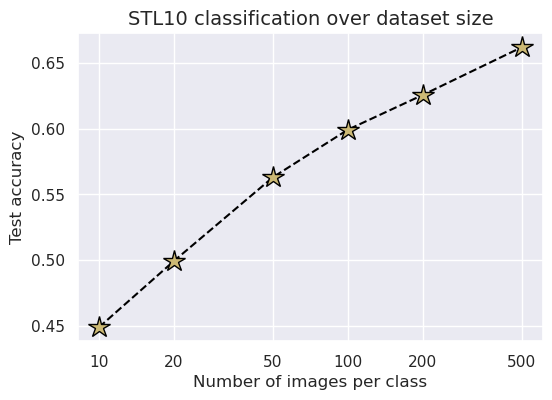

Test accuracy for  10 images per label: 44.87%
Test accuracy for  20 images per label: 49.92%
Test accuracy for  50 images per label: 56.31%
Test accuracy for 100 images per label: 59.94%
Test accuracy for 200 images per label: 62.59%
Test accuracy for 500 images per label: 66.22%


In [33]:
# Plot the results

dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")

**Discussion On Results**

I replaced SimCLR with BYOL and repeated the downstream classification experiments. BYOL consistently outperformed SimCLR across all label budgets. For instance, with only 10 labeled images per class, BYOL achieved 44.87%, compared to 40.36% with SimCLR. This performance gap widened as more labels were introduced — BYOL reached 66.22% at 500 images per class, outperforming SimCLR by approximately 4%.

Despite BYOL’s superior results over SimCLR, the fully supervised baseline still achieved the highest test accuracy (73.68%), reflecting the value of end-to-end label supervision. Nevertheless, BYOL's performance shows that it learns high-quality, transferable representations, and may be better suited for low-label regimes or when data augmentation is critical.

These results validate that the choice of SSL method has a significant impact on downstream performance and that methods like BYOL can offer meaningful gains even over strong contrastive approaches like SimCLR.

# References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020). A simple framework for contrastive learning of visual representations. In International conference on machine learning (pp. 1597-1607). PMLR. ([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020). Big self-supervised models are strong semi-supervised learners. NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O. (2018). Representation learning with contrastive predictive coding. arXiv preprint arXiv:1807.03748. ([link](https://arxiv.org/abs/1807.03748))

[4] Grill, J.B., Strub, F., Altché, F., Tallec, C., Richemond, P.H., Buchatskaya, E., Doersch, C., Pires, B.A., Guo, Z.D., Azar, M.G. and Piot, B. (2020). Bootstrap your own latent: A new approach to self-supervised learning. arXiv preprint arXiv:2006.07733. ([link](https://arxiv.org/abs/2006.07733))

[5] Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., Maschinot, A., Liu, C. and Krishnan, D. (2020). Supervised contrastive learning. arXiv preprint arXiv:2004.11362. ([link](https://arxiv.org/abs/2004.11362))

[6] Zbontar, J., Jing, L., Misra, I., LeCun, Y. and Deny, S. (2021). Barlow twins: Self-supervised learning via redundancy reduction. arXiv preprint arXiv:2103.03230. ([link](https://arxiv.org/abs/2103.03230))